The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [12]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

In [13]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [14]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [59]:
def load_exp_data(direc, cut=None, layer_size=20, name_frags=[]):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
    
    for i_f in range(0, len(file_names)):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        summed_incoming_weights = loaded['w_r_e_summed']
        
        try:
            exc_cells_initially_active = loaded['exc_raster']
            exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :]
            exc_cells_newly_active = None
        except KeyError as e:
            exc_cells_initially_active = loaded['exc_cells_initially_active']
            exc_cells_newly_active = loaded['exc_cells_newly_active']
        inh_raster = loaded['inh_raster']
        
        try:
            surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
        except KeyError as e:
            surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)
        
        first_spk_times = process_single_activation(exc_cells_initially_active, 900)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
            
        data = {
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'exc_cells_initially_active': exc_cells_initially_active,
            'exc_cells_newly_active': exc_cells_newly_active,
            'inh_raster': inh_raster,
            'freqs': loaded['freqs'][0],
            'spk_bins': loaded['spk_bins'][0],
            'surviving_cell_indices': surviving_cell_indices,
        }
        yield i_f, data

### Figure 1: rasters of the chain pre-perturbation, directly post-perturbation, and recovered (with all plasticity rules in effect)

In [155]:
def make_figure_1(name):
    scale = 1.1
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15 * scale, 4 * scale))
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        timepoints = [0, 1, 5, 79]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 0.2e-3 * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.2)
                    if len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 0.2e-3 * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='red', zorder=0, alpha=1)
                axs[j].set_ylim(150, 1350)
                axs[j].set_xlim(.015 * 1000, 0.115 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                set_font_size(axs[j], 16)
                j += 1
    
    fig.tight_layout()
        

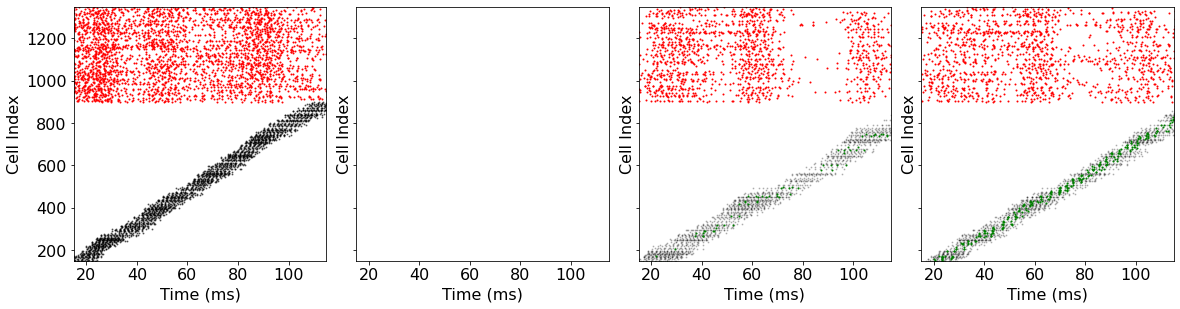

In [156]:
make_figure_1('all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:48--27:2193')

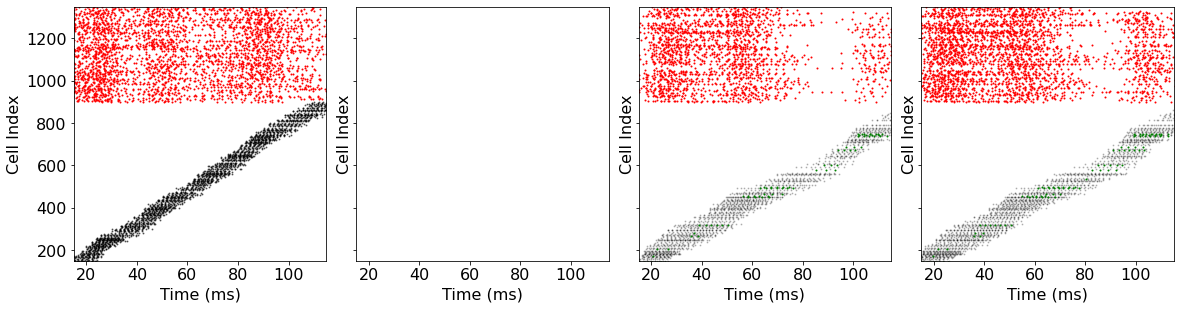

In [157]:
make_figure_1('pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:55--11:2193')

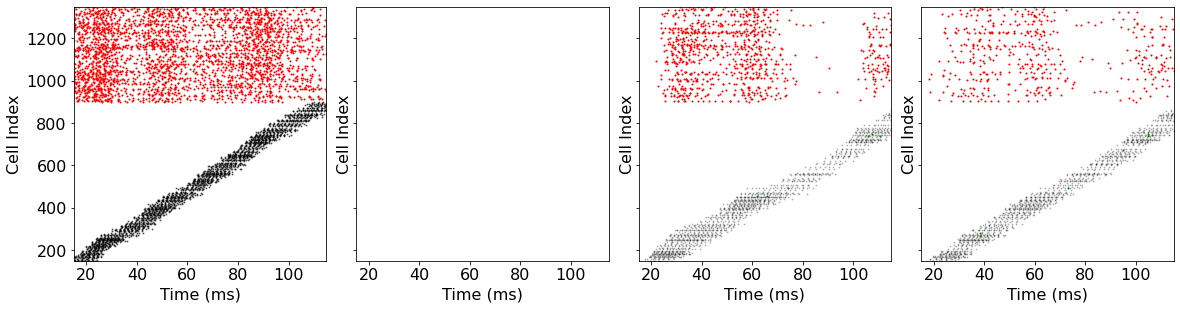

In [158]:
make_figure_1('single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:58--56:2193')

### Figure 2: comparisons of the summed synaptic strengths per HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [188]:
def make_figure_2_median(names, ylim=(0, 4)):
    scale = 1.1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    
    for idx, exp_dir_names in enumerate(sorted(all_dirs)):
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            all_median_incoming_summed_weights = []
            baseline_median = None
            cap=80

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_median_incoming_summed_weights.append(np.median(data['summed_incoming_weights']))

                if i == 0:
                    baseline_median = np.median(data['summed_incoming_weights'])

            all_median_incoming_summed_weights = np.array(all_median_incoming_summed_weights) / baseline_median
            
            if j == 0:
                axs.plot(np.arange(cap) * 10, all_median_incoming_summed_weights, lw=1., color=spaced_colors[idx], label=labels[idx])
            else:
                axs.plot(np.arange(cap) * 10, all_median_incoming_summed_weights, lw=1., color=spaced_colors[idx])
        axs.set_xlim(0, cap * 10)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Median summed synapse strength')
        axs.legend()
        set_font_size(axs, 16)
    
    fig.tight_layout()

[['all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:48--27:2193', 'all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--01:25--23:1354'], ['pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:55--11:2193', 'pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--01:30--19:1354'], ['single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:44--14:1354', 'single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:58--56:2193']]


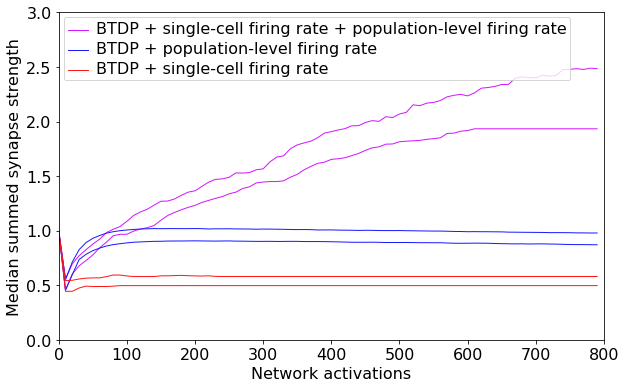

In [190]:
make_figure_2_median(['all_rules', 'pop', 'single_cell'], ylim=(0, 3))

In [192]:
def make_figure_2(names, ylim=(0, 2)):
    scale = 1.1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(sorted(all_dirs)):
        for j, exp_dir_name in enumerate(exp_dir_names):
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            baseline_mean = None
            baseline_std = None
            cap=80

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                    all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])

                if i == 0:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean

    #         axs.fill_between(np.arange(cap), all_mean_incoming_summed_weights - all_std_incoming_summed_weights, all_mean_incoming_summed_weights + all_std_incoming_summed_weights,
    #                          alpha=0.1, color=spaced_colors[idx], zorder=-idx)
            if j == 0:
                axs.plot(np.arange(cap) * 10, all_mean_incoming_summed_weights, lw=1., color=spaced_colors[idx], label=labels[idx])
            else:
                axs.plot(np.arange(cap) * 10, all_mean_incoming_summed_weights, lw=1., color=spaced_colors[idx])
        axs.set_xlim(0, cap * 10)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Mean summed synapse strength')
        axs.legend()
        set_font_size(axs, 16)
        
    
    fig.tight_layout()


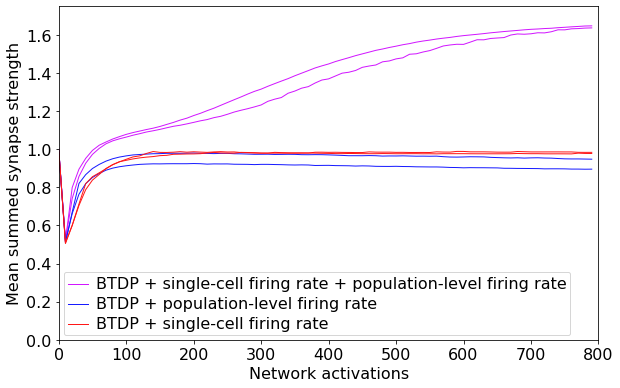

In [197]:
make_figure_2(['all_rules', 'pop', 'single_cell'], ylim=(0, 1.75))

In [272]:
def make_figure_2_alt(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(3, 1, sharex=False, sharey=True, figsize=(8 * scale, 10 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    step = 5
    cap=79
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        all_incoming_summed_weights = []
        
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]), name_frags=['dropout_0']):
            if i % step != 0:
                continue
            if i >= cap:
                break
            all_incoming_summed_weights.append(data['summed_incoming_weights'])
        
        x = np.arange(0, cap, step)
        print(all_incoming_summed_weights)
        parts = axs[idx].violinplot(all_incoming_summed_weights, x, widths=np.ones(len(x)) * step * 0.5,
                      showmedians=True)
        
        axs[idx].set_xlim(-0.5 * step, cap)
        axs[idx].set_ylim(ylim[0], ylim[1])
        if idx == len(all_dirs) - 1:
            axs[idx].set_xlabel('Network activations')
        axs[idx].set_ylabel('Summed synapse strength\n onto excitatory cells')
#         axs.legend()

        for pc in parts['bodies']:
            pc.set_facecolor(spaced_colors[idx])
            pc.set_edgecolor(spaced_colors[idx])
            pc.set_alpha(0.5)
        
        for part_type in ['cmaxes', 'cmins', 'cbars', 'cmedians']:
            parts[part_type].set_color('black')
            
        
    fig.tight_layout()

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.52900128e-04, 3.49181490e-04, 1.17442134e-03, 1.33468311e-03,
        1.02564655e-03, 2.85620666e-04, 1.71265280e-04, 2.38628402e-04,
        2.10643607e-04, 4.09663803e-05, 1.52605096e-03, 1.07028234e-03,
        1.24122026e-03, 2.10194671e-04, 1.24501868e-03, 2.49353939e-04,
        1.30510583e-03, 1.76685871e-04, 9.42125765e-04, 1.19284801e-03,
        1.17042811e-03, 2.52917240e-04, 1.61472831e-04, 1.71708265e-04,
        1.68190454e-04, 3.33680116e-05, 9.06733238e-05, 2.48594029e-04,
        2.79439154e-04, 1.03832586e-03, 1.07290127e-03, 1.13443360e-04,
        1.13988538e-03, 1.33813849e-04, 1.02473275e-03, 9.14227

ValueError: X must have 2 or fewer dimensions

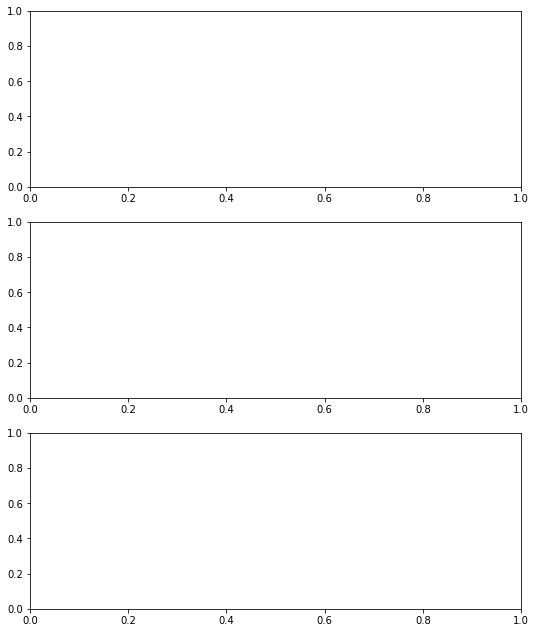

In [273]:
make_figure_2_alt([
    'all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--01:25--23:1354',
    'pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--01:30--19:1354',
    'single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:44--14:1354',
], ylim=(-0.0001, 0.008))

### Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [244]:
def make_figure_3(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(18 * scale, 8 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#1f22ff', 'black', '#ff1f71']
    labels = [
        'unperturbed',
        'perturbed',
        '800th rendition',
    ]
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        timepoints = [0, 1, 79]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]), name_frags=['dropout_0']):
            if j < len(timepoints) and i == timepoints[j]:                
                spk_bins = data['spk_bins']
                freqs = data['freqs']
                if idx == 0:
                    axs[idx, j].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j, width=1, label=labels[j])
                else:
                    axs[idx, j].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j, width=1)
                axs[idx, j].set_ylabel('Frequency')
                if idx == (len(all_dirs) - 1):
                    axs[idx, j].set_xlabel('Spks per neuron')
                axs[idx, j].set_xlim(-0.5, 20)
                axs[idx, j].set_ylim(0, 450)
                
                if idx == 0:
                    axs[0, j].legend()
                    
                set_font_size(axs[idx, j], 18)
                j += 1

            
    
    fig.tight_layout()

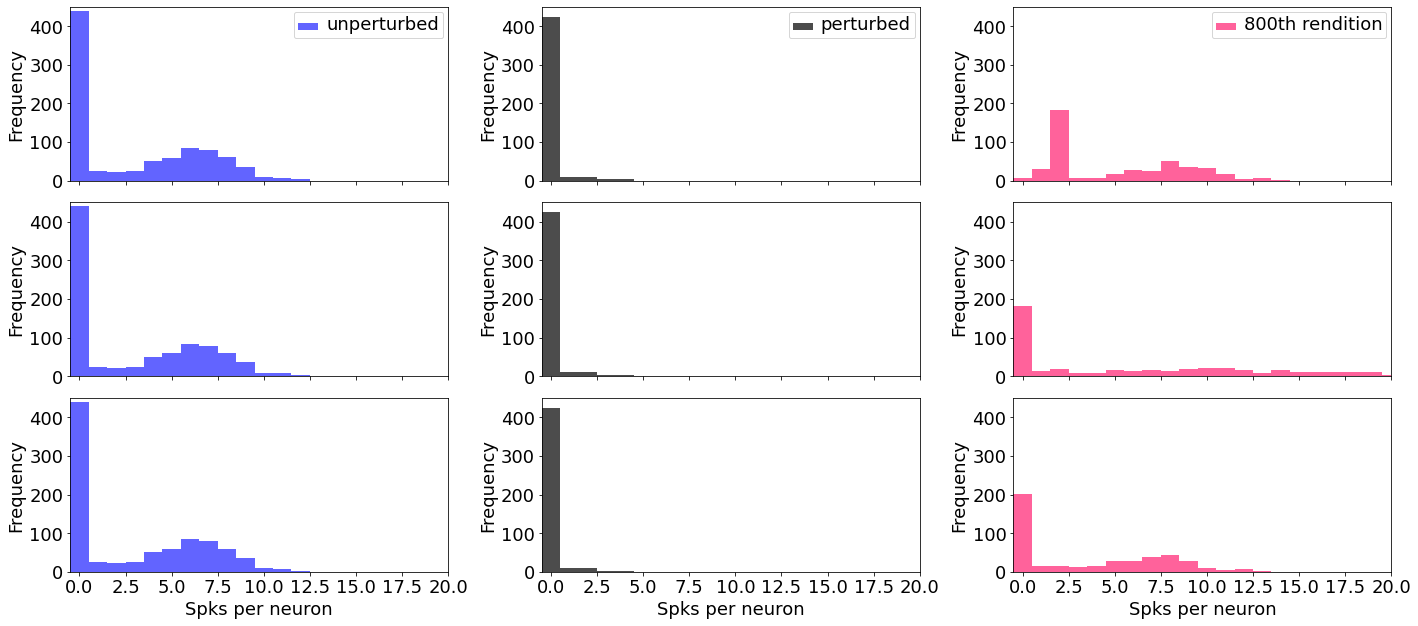

In [245]:
make_figure_3([
    'all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:48--27:2193',
    'pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:55--11:2193',
    'single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-25--07:58--56:2193',
])

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

<b>Make into 9 instead of 3.</b>

In [284]:
def make_figure_4(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(8 * scale, 12 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(20) * i for i in range(0, 900, 20)])
    cap = 80
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(sorted(all_dirs)):
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            pop_firing_rates = []
            relative_prop_speeds = []
            r_squareds = []
            last_layer_actives = []

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i == cap:
                    break

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                pop_firing_rates.append(pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(x_firing, first_spk_times_nonnan)
                relative_prop_speeds.append(res.slope)
                r_squareds.append(np.square(res.rvalue))
                last_layer_actives.append(data['last_layer_active'])

            epochs = np.arange(cap)
            
            axs[0].plot(epochs, pop_firing_rates, c=spaced_colors[idx], lw=1.)
#             if j == 0:
#                 axs[1].plot(epochs, relative_prop_speeds, c=spaced_colors[idx], lw=1., label=labels[i])
#             else: 
            axs[1].plot(epochs, relative_prop_speeds, c=spaced_colors[idx], lw=1.)
            axs[2].plot(epochs, r_squareds,c=spaced_colors[idx], lw=1.)
            axs[3].plot(epochs, last_layer_actives, c=spaced_colors[idx], lw=1.)
        
        axs[0].set_ylabel('Population spks\nper activation')
        axs[1].set_ylabel('Propagation speed')
        axs[2].set_ylabel(r'$R^2$')
        axs[3].set_ylabel('Last layer active')
        axs[3].set_xlabel('Epochs')
        
        axs[1].set_ylim(0, .8)
        axs[3].set_ylim(0, 45)
        
        axs[1].legend()
        
        for i in range(4):
            axs[i].set_xlim(0, cap)
            set_font_size(axs[i], 16)
    
    fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


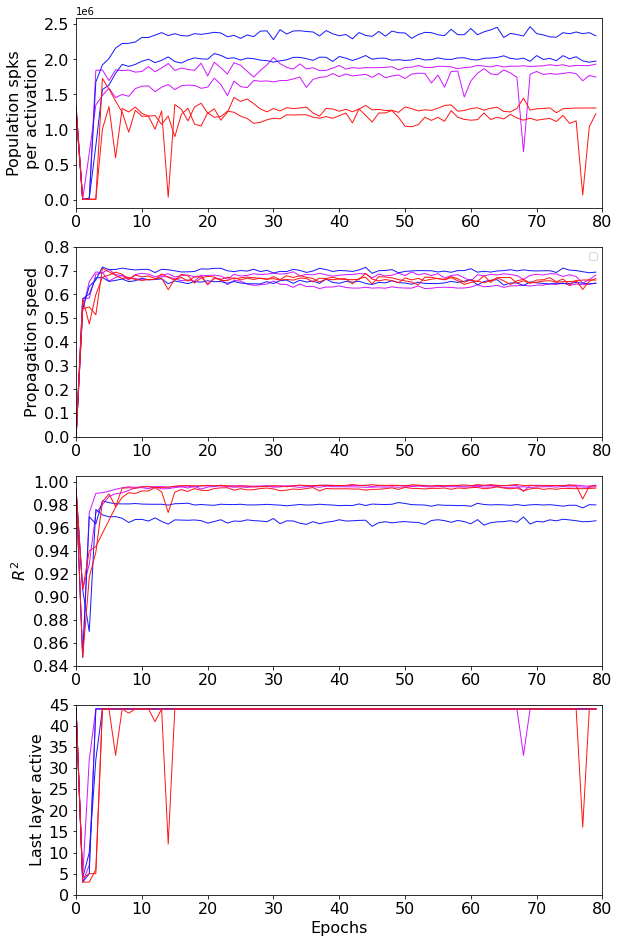

In [285]:
make_figure_4(['all_rules', 'pop','single_cell'])